# Производим импорт необходимых библиотек и считывание из них данных

In [3]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

DATA_PATH = './data/'
df_demo = pd.read_spss(DATA_PATH + 'demo2017.sav')
df_health = pd.read_spss(DATA_PATH + 'health2017.sav')
df_income = pd.read_spss(DATA_PATH + 'income2017.sav')
# Приводим всё к одному регистру
df_demo.columns = df_demo.columns.str.lower()
df_health.columns = df_health.columns.str.lower()
df_income.columns = df_income.columns.str.lower()

def get_stats(df_column : pd.Series):
    """
    Takes pandas Series and returns it's string representation
    """
    col_mean = df_column.mean()
    col_median = df_column.median()
    col_mode = df_column.mode()[0]
    col_std = df_column.std()
    col_skew = df_column.skew()
    col_kurt = df_column.kurt()
    return f"""
            n_obs: {len(df_column)}
            mean: {col_mean:.3f}, median: {col_median:.3f}, mode: {col_mode:.3f}
            std: {col_std:.3f}, skewness: {col_skew:.3f}, kurtosis: {col_kurt:.3f}
            """
            
def standardize(df_column : pd.Series):
    idxs = df_column.index
    return pd.Series(StandardScaler().fit_transform(np.array(df_column).reshape(-1,1))[:,0], idxs)

# 1. Подготовим данные для 4 варианта заданий

## Объединим данные по членам домохозяйств в один датафрейм

Достаточно сделать merge по n_uhc и n_upc, т.к. они задают уникального члена домашнего домохозяйства, но чтобы ['age', 'region', 'resid', 'sex'] не дублировались, сделаем merge по всем общим колонкам. Таким образом мы дополнительно проконтролируем, что выбираем достоверные наблюдения, у которых совпадают не только уникальные коды, но и ['age', 'region', 'resid', 'sex'] (а они должны совпадать для обоих датафреймов)

Длина нового датафрейма, содержащего данные по всем членам домохозяйств на одну строку меньше, чем размер df_health (связано с тем, что какой-то из признаков всё-таки не совпадал в df_demo и df_health или о каком-то члене домохозяйства не было данных в df_demo)

Количество признаков в df_person равно 16 (количество признаков в df_demo (11) + количество признаков в df_health (11) - размер их пересечения (6) )

In [4]:
print("Общие столбцы в demo и health датафреймах", np.intersect1d(df_demo.columns, df_health.columns))
print("Общие столбцы в demo и income датафреймах", np.intersect1d(df_demo.columns, df_income.columns))
print("Общие столбцы в health и income датафреймах", np.intersect1d(df_health.columns, df_income.columns))

df_person = df_demo.merge(df_health, on=np.intersect1d(df_demo.columns, df_health.columns).tolist())
print(df_person.shape)
df_person.head()

Общие столбцы в demo и health датафреймах ['age' 'n_uhc' 'n_upc' 'region' 'resid' 'sex']
Общие столбцы в demo и income датафреймах ['n_uhc' 'region' 'resid' 'year' 'yweight']
Общие столбцы в health и income датафреймах ['n_uhc' 'region' 'resid']
(11111, 16)


,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker
0,1.0,1.0,2017.0,504.560908,Large city,Brest oblast,66.0,Female,0.0,0.0,"Higher education, After Higher education",Bad,62.0,165.0,"Yes, in free time",No
1,2.0,1.0,2017.0,463.977546,Large city,Brest oblast,61.0,Male,0.0,0.0,Secondary specialized education,"Not very good, but not bad",73.0,165.0,"Yes, in free time",No
2,2.0,2.0,2017.0,463.977546,Large city,Brest oblast,60.0,Female,0.0,0.0,Secondary specialized education,"Not very good, but not bad",76.0,163.0,"Yes, in free time",No
3,3.0,1.0,2017.0,504.560908,Large city,Brest oblast,38.0,Female,0.0,0.0,Secondary specialized education,"Not very good, but not bad",83.0,160.0,"Yes, in free time",No
4,3.0,2.0,2017.0,504.560908,Large city,Brest oblast,63.0,Female,0.0,0.0,Secondary specialized education,Bad,73.0,163.0,No,No


## Объединим данные по членам домохозяйств с данными по их домохозяйствам

Для этого сделаем merge по по общим колонкам в df_person и df_income (как и в прошлом случае, достаточно только кода домохозяйства n_uhc, но для дополнительной проверки достоверности данных и во избежание дубликатов колонок объединение сделаем по всем общим колонкам)

Количество строк сохранилось, а количество признаков стало равно 72 (количество признаков в df_income (61) + количество признаков в df_person (16) - размер их пересечения (5) )

In [5]:
print("Общие столбцы в person и income датафреймах", np.intersect1d(df_person.columns, df_income.columns))
full_df = df_person.merge(df_income, on=np.intersect1d(df_person.columns, df_income.columns).tolist())
print("Полный датафрейм:", full_df.shape)
full_df.head()

Общие столбцы в person и income датафреймах ['n_uhc' 'region' 'resid' 'year' 'yweight']
Полный датафрейм: (11111, 72)


,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker,htype,hsize,ch0_5,ch6_12,ch13_17,elder,inc_1,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,inc_8,inc_9,inc_10,inc_11,cashinc,inkind,privlg,totalinc,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_6_1,exp_6_2,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16,exp_17,exp_17_1,exp_18,exp_19,exp_20,exp_21,exp_22,exp_23,exp_24,exp_25,exp_26,totalexp,hh_blint,hh_int1,hh_int2,hh_int3,hh_int4
0,1.0,1.0,2017.0,504.560908,Large city,Brest oblast,66.0,Female,0.0,0.0,"Higher education, After Higher education",Bad,62.0,165.0,"Yes, in free time",No,Lone adult older working age,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,321.471667,0.0,0.000,0.0,12.500000,0.0,0.0,0.000000,333.971667,0.000000,0.000000,333.971667,184.456667,0.000000,16.123333,0.00,0.0,15.879167,0.0,0.000000,40.181667,0.0,56.729167,11.291667,0.000000,0.0,0.416667,11.173333,0.0,0.0,2.935833,2.935833,13.885000,1.666667,0.0,0.0,3.333333,0.0,0.0,5.833333,0.0,363.905833,1.0,1.0,1.0,1.0,1.0
1,2.0,1.0,2017.0,463.977546,Large city,Brest oblast,61.0,Male,0.0,0.0,Secondary specialized education,"Not very good, but not bad",73.0,165.0,"Yes, in free time",No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,729.666667,0.0,0.000,0.0,4.166667,0.0,0.0,0.000000,733.833333,42.437329,66.760833,843.031496,419.575417,2.952083,7.816667,0.00,0.0,53.674167,0.0,53.674167,6.108333,0.0,22.750000,18.944167,1.033333,0.0,26.704167,14.705833,0.0,0.0,0.000000,0.000000,18.061667,13.333333,6.9,0.0,0.000000,0.0,0.0,125.833333,0.0,738.392500,1.0,1.0,1.0,1.0,1.0
2,2.0,2.0,2017.0,463.977546,Large city,Brest oblast,60.0,Female,0.0,0.0,Secondary specialized education,"Not very good, but not bad",76.0,163.0,"Yes, in free time",No,All adults older working age,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,729.666667,0.0,0.000,0.0,4.166667,0.0,0.0,0.000000,733.833333,42.437329,66.760833,843.031496,419.575417,2.952083,7.816667,0.00,0.0,53.674167,0.0,53.674167,6.108333,0.0,22.750000,18.944167,1.033333,0.0,26.704167,14.705833,0.0,0.0,0.000000,0.000000,18.061667,13.333333,6.9,0.0,0.000000,0.0,0.0,125.833333,0.0,738.392500,1.0,1.0,1.0,1.0,1.0
3,3.0,1.0,2017.0,504.560908,Large city,Brest oblast,38.0,Female,0.0,0.0,Secondary specialized education,"Not very good, but not bad",83.0,160.0,"Yes, in free time",No,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.100000,0.0,68.275,0.0,200.000000,0.0,0.0,33.366667,401.741667,16.448662,50.312500,468.502828,154.219167,1.056250,6.620000,1.25,0.0,41.110833,0.0,41.110833,4.236667,0.0,6.974167,11.025000,2.500000,0.0,31.880000,14.930833,0.0,0.0,26.616667,26.616667,5.169167,59.354167,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,366.942917,1.0,1.0,1.0,1.0,1.0
4,3.0,2.0,2017.0,504.560908,Large city,Brest oblast,63.0,Female,0.0,0.0,Secondary specialized education,Bad,73.0,163.0,No,No,Lone person (no pensioner),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.100000,0.0,68.275,0.0,200.000000,0.0,0.0,33.366667,401.741667,16.448662,50.312500,468.502828,154.219167,1.056250,6.620000,1.25,0.0,41.110833,0.0,41.110833,4.236667,0.0,6.974167,11.025000,2.500000,0.0,31.880000,14.930833,0.0,0.0,26.616667,26.616667,5.169167,59.354167,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,366.942917,1.0,1.0,1.0,1.0,1.0


## Выберем с помощью случайного выбора (без повторений) подвыборку в 2000 человек

In [6]:
np.random.seed(20001109)
idxs = np.random.choice(full_df.index, 2000, replace=False)
df = full_df.iloc[idxs].copy()
df.head()

,n_uhc,n_upc,year,yweight,resid,region,age,sex,ppinc_1,nummonth,educat,healthev,weight,height,sport,smoker,htype,hsize,ch0_5,ch6_12,ch13_17,elder,inc_1,inc_2,inc_3,inc_4,inc_5,inc_6,inc_7,inc_8,inc_9,inc_10,inc_11,cashinc,inkind,privlg,totalinc,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_6_1,exp_6_2,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16,exp_17,exp_17_1,exp_18,exp_19,exp_20,exp_21,exp_22,exp_23,exp_24,exp_25,exp_26,totalexp,hh_blint,hh_int1,hh_int2,hh_int3,hh_int4
9460,5251.0,1.0,2017.0,535.998033,Rural,Minsk oblast,42.0,Male,759.468333,12.0,Secondary education,Good,83.0,178.0,No,Yes,2 and more adults with children,3.0,1.0,0.0,0.0,0.0,791.135000,3.250000,0.000,0.000000,268.578333,0.000000,0.0,18.621667,6.916667,0.0,0.0,1088.501667,57.516407,0.000000,1146.018074,374.127917,41.539583,15.251667,6.382500,0.000000,53.702500,0.0,53.702500,18.576667,135.416667,11.240000,0.491667,0.000000,0.0,37.480833,9.710833,0.000000,0.000000,20.497917,20.497917,36.109167,1.395833,1.379167,264.333333,0.0,0.0,7.38,0.000000,0.0,1035.016250,1.0,1.0,1.0,1.0,1.0
5545,3031.0,1.0,2017.0,544.369792,Small city,Grodno oblast,73.0,Female,0.000000,0.0,"Higher education, After Higher education",Bad,70.0,168.0,No,No,Lone adult older working age,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000,416.653333,0.000000,59.708333,0.0,58.333333,0.000000,0.0,0.0,534.695000,30.134244,5.556667,570.385910,248.321667,3.656250,15.914167,12.666667,0.000000,41.196667,0.0,26.853333,32.473333,0.000000,18.674167,2.166667,0.000000,0.0,10.165000,25.096667,0.000000,0.000000,64.166667,64.166667,4.390000,100.500000,0.000000,0.000000,0.0,0.0,0.00,46.166667,0.0,625.554583,1.0,1.0,1.0,1.0,1.0
297,162.0,1.0,2017.0,463.977546,Large city,Brest oblast,56.0,Male,396.034167,12.0,Secondary education,"Not very good, but not bad",83.0,164.0,No,No,Household without children,2.0,0.0,0.0,0.0,1.0,627.658333,0.000000,5.655,326.636667,0.000000,0.000000,0.0,25.000000,0.000000,0.0,0.0,984.950000,0.000000,1.183333,986.133333,332.752500,0.000000,18.015833,12.509167,0.000000,43.336667,0.0,42.525833,28.556667,0.000000,35.863333,60.962500,0.000000,0.0,46.181667,13.168333,0.000000,0.000000,0.000000,0.000000,12.888333,7.904167,0.000000,0.000000,0.0,0.0,0.00,320.250000,0.0,932.389167,1.0,1.0,1.0,1.0,1.0
6638,3640.0,3.0,2017.0,2056.181878,Minsk city,Minsk city,23.0,Male,795.587500,12.0,"Higher education, After Higher education",Good,75.0,181.0,"Yes, in free time",No,Household without children,3.0,0.0,0.0,0.0,1.0,1646.670833,0.000000,0.000,317.960000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1964.630833,15.771167,52.630833,2033.032833,399.434583,52.211250,54.430833,64.367500,1.943333,57.534167,0.0,52.117500,46.004167,5.550000,21.086667,92.106667,0.000000,0.0,69.598333,95.849167,0.000000,0.000000,83.307500,49.974167,26.252500,11.021667,0.000000,787.916667,19.5,0.0,0.00,26.000000,0.0,1914.115000,1.0,1.0,1.0,1.0,1.0
10072,5581.0,5.0,2017.0,3008.156165,Large city,Mogilev oblast,73.0,Female,0.000000,0.0,Vocational school,"Not very good, but not bad",110.0,165.0,No,No,2 and more adults with children,5.0,1.0,1.0,0.0,1.0,869.436667,3.833333,0.000,317.911667,89.593333,0.000000,0.0,45.833333,0.000000,0.0,0.0,1326.608333,93.067562,24.137500,1443.813395,514.836250,68.897917,42.862500,22.541667,0.000000,126.276667,0.0,122.186667,32.430000,11.930000,57.556667,34.632500,101.816667,0.0,26.518333,126.631667,8.048333,30.601667,4.647500,0.000000,15.283333,53.905833,19.675833,0.000000,0.0,0.0,62.50,6.950000,0.0,1368.543333,1.0,1.0,1.0,1.0,1.0


## Подготовим взвешенный вариант выборки

1. Округлим вес выборки (yweight) до целого числа
2. "Повторим" каждую запись yweight раз с помощью df.loc[df.index.repeat(df["yweight"])]
3. Проверим, равна ли сумма всех yweight в исходном датафрейме количеству строк взвешенного датафрейма

In [7]:
df["yweight"] = df["yweight"].astype(int)
df["weight"] = df["weight"].astype(float)
df["height"] = df["height"].astype(float)

for col in df.columns[df.dtypes == 'category']:
    df[col] = df[col].astype(str)

df = df.replace({"nan" : pd.NA, "DKR" : pd.NA, "Not in Universe" : pd.NA})

df["bmi"] = df["weight"]/((df["height"]/100)**2)
df["savings"] = df["totalinc"]-df["totalexp"]

weighted_df = df.loc[df.index.repeat(df["yweight"])].copy()

print("Размер взвешенной выборки:", weighted_df.shape)

is_weighted_correctly = df["yweight"].sum() == len(weighted_df)
print("Взвешено корректно?", is_weighted_correctly)

# Uncomment following block for data saving
if is_weighted_correctly:
    df.to_csv(DATA_PATH + "df.csv")
    weighted_df.to_csv(DATA_PATH + "weighted_df.csv")
    print("Data saving completed.")

Размер взвешенной выборки: (1282939, 74)
Взвешено корректно? True
Data saving completed.


# 2. Проведём анализ распределений переменных

Так как мой вариант - 7, то кроме общих переменных я использую inc_4 (пенсии) и exp_4 (расходы на обувь) для анализа

Переменная totalinc имеет лог-нормальное распределение, основные наблюдения сконцентрированы от 0 до 2200.

Text(0.5, 0, 'totalexp')

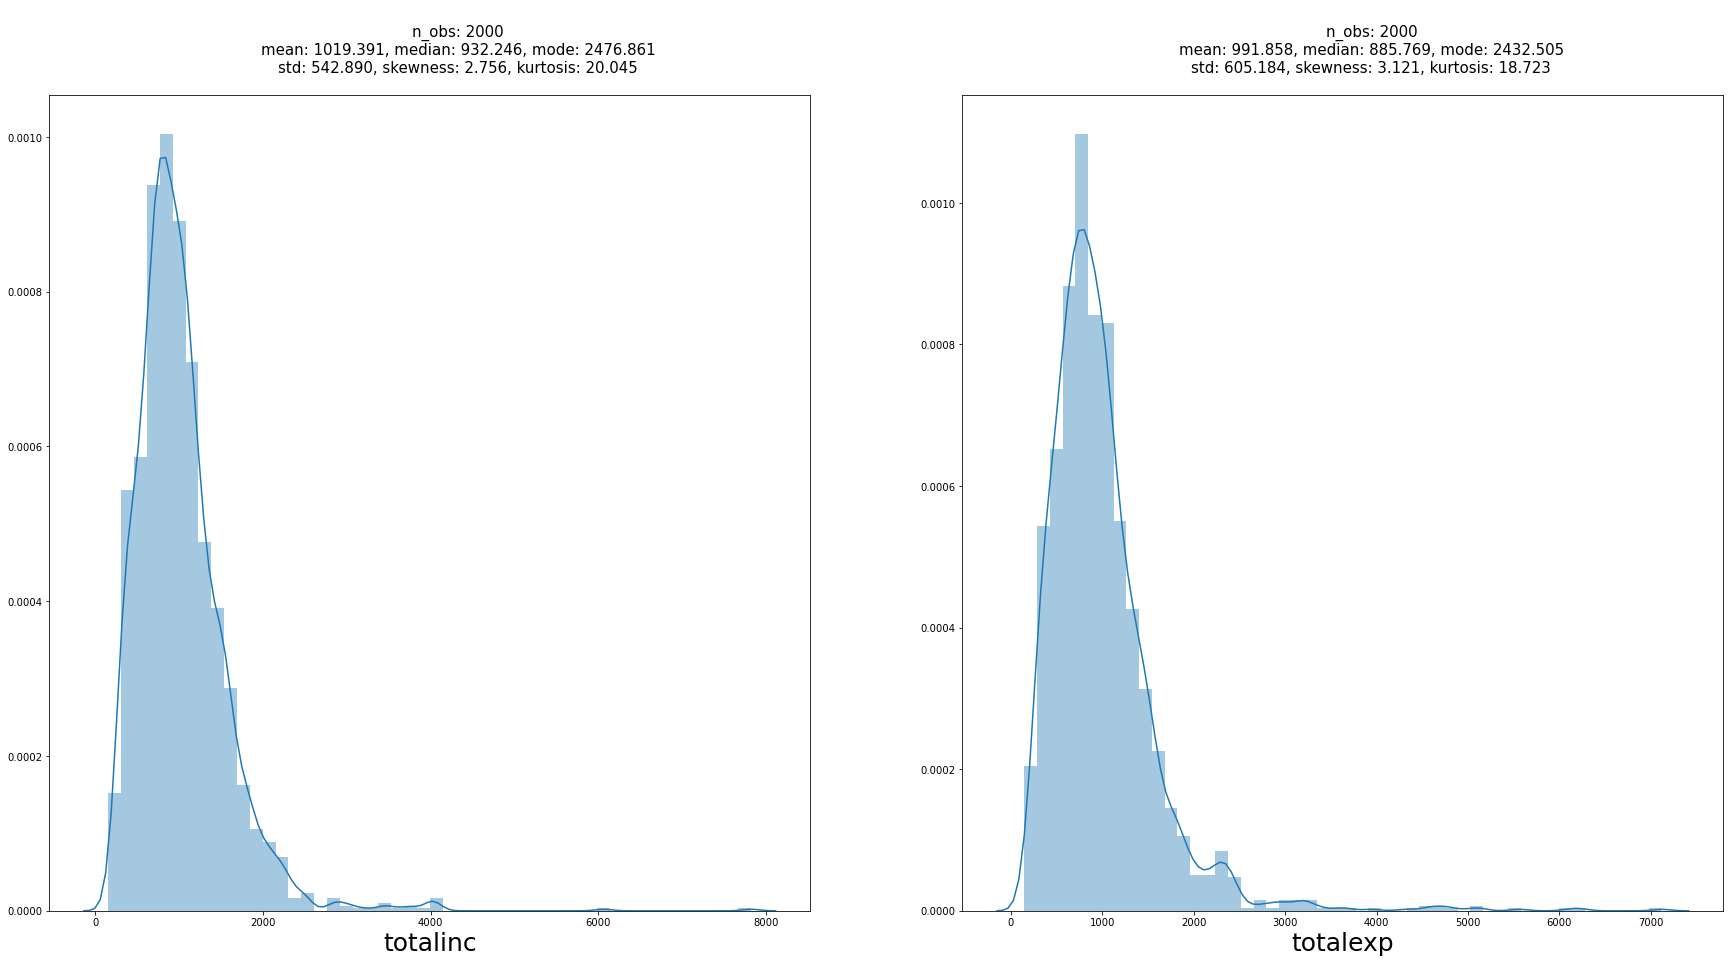

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

sns.distplot(df["totalinc"], ax=axes[0]).set_title(
    get_stats(df["totalinc"]), fontsize=15)
axes[0].set_xlabel("totalinc", fontsize=25)

sns.distplot(df["totalexp"], ax=axes[1]).set_title(
    get_stats(df["totalexp"]), fontsize=15)
axes[1].set_xlabel("totalexp", fontsize=25)

Рассматривая статьи inc_4 (пенсии) и exp_4 (расходы на обувь) можно увидеть, что:
1. В inc_4 видим, что этот признак для большинства наблюдений равен 0, оставшиеся распределяются с 150 до 1600. Доля этой графы во всех доходах в среднем равна 4%.
2. В exp_4 для большинства наблюдений лежит в интервале 0-50, а для оставшихся большинство значений сконцентрировано до 160.

Text(0.5, 0, 'exp_4 часть в totalexp [где exp_4 != 0]')

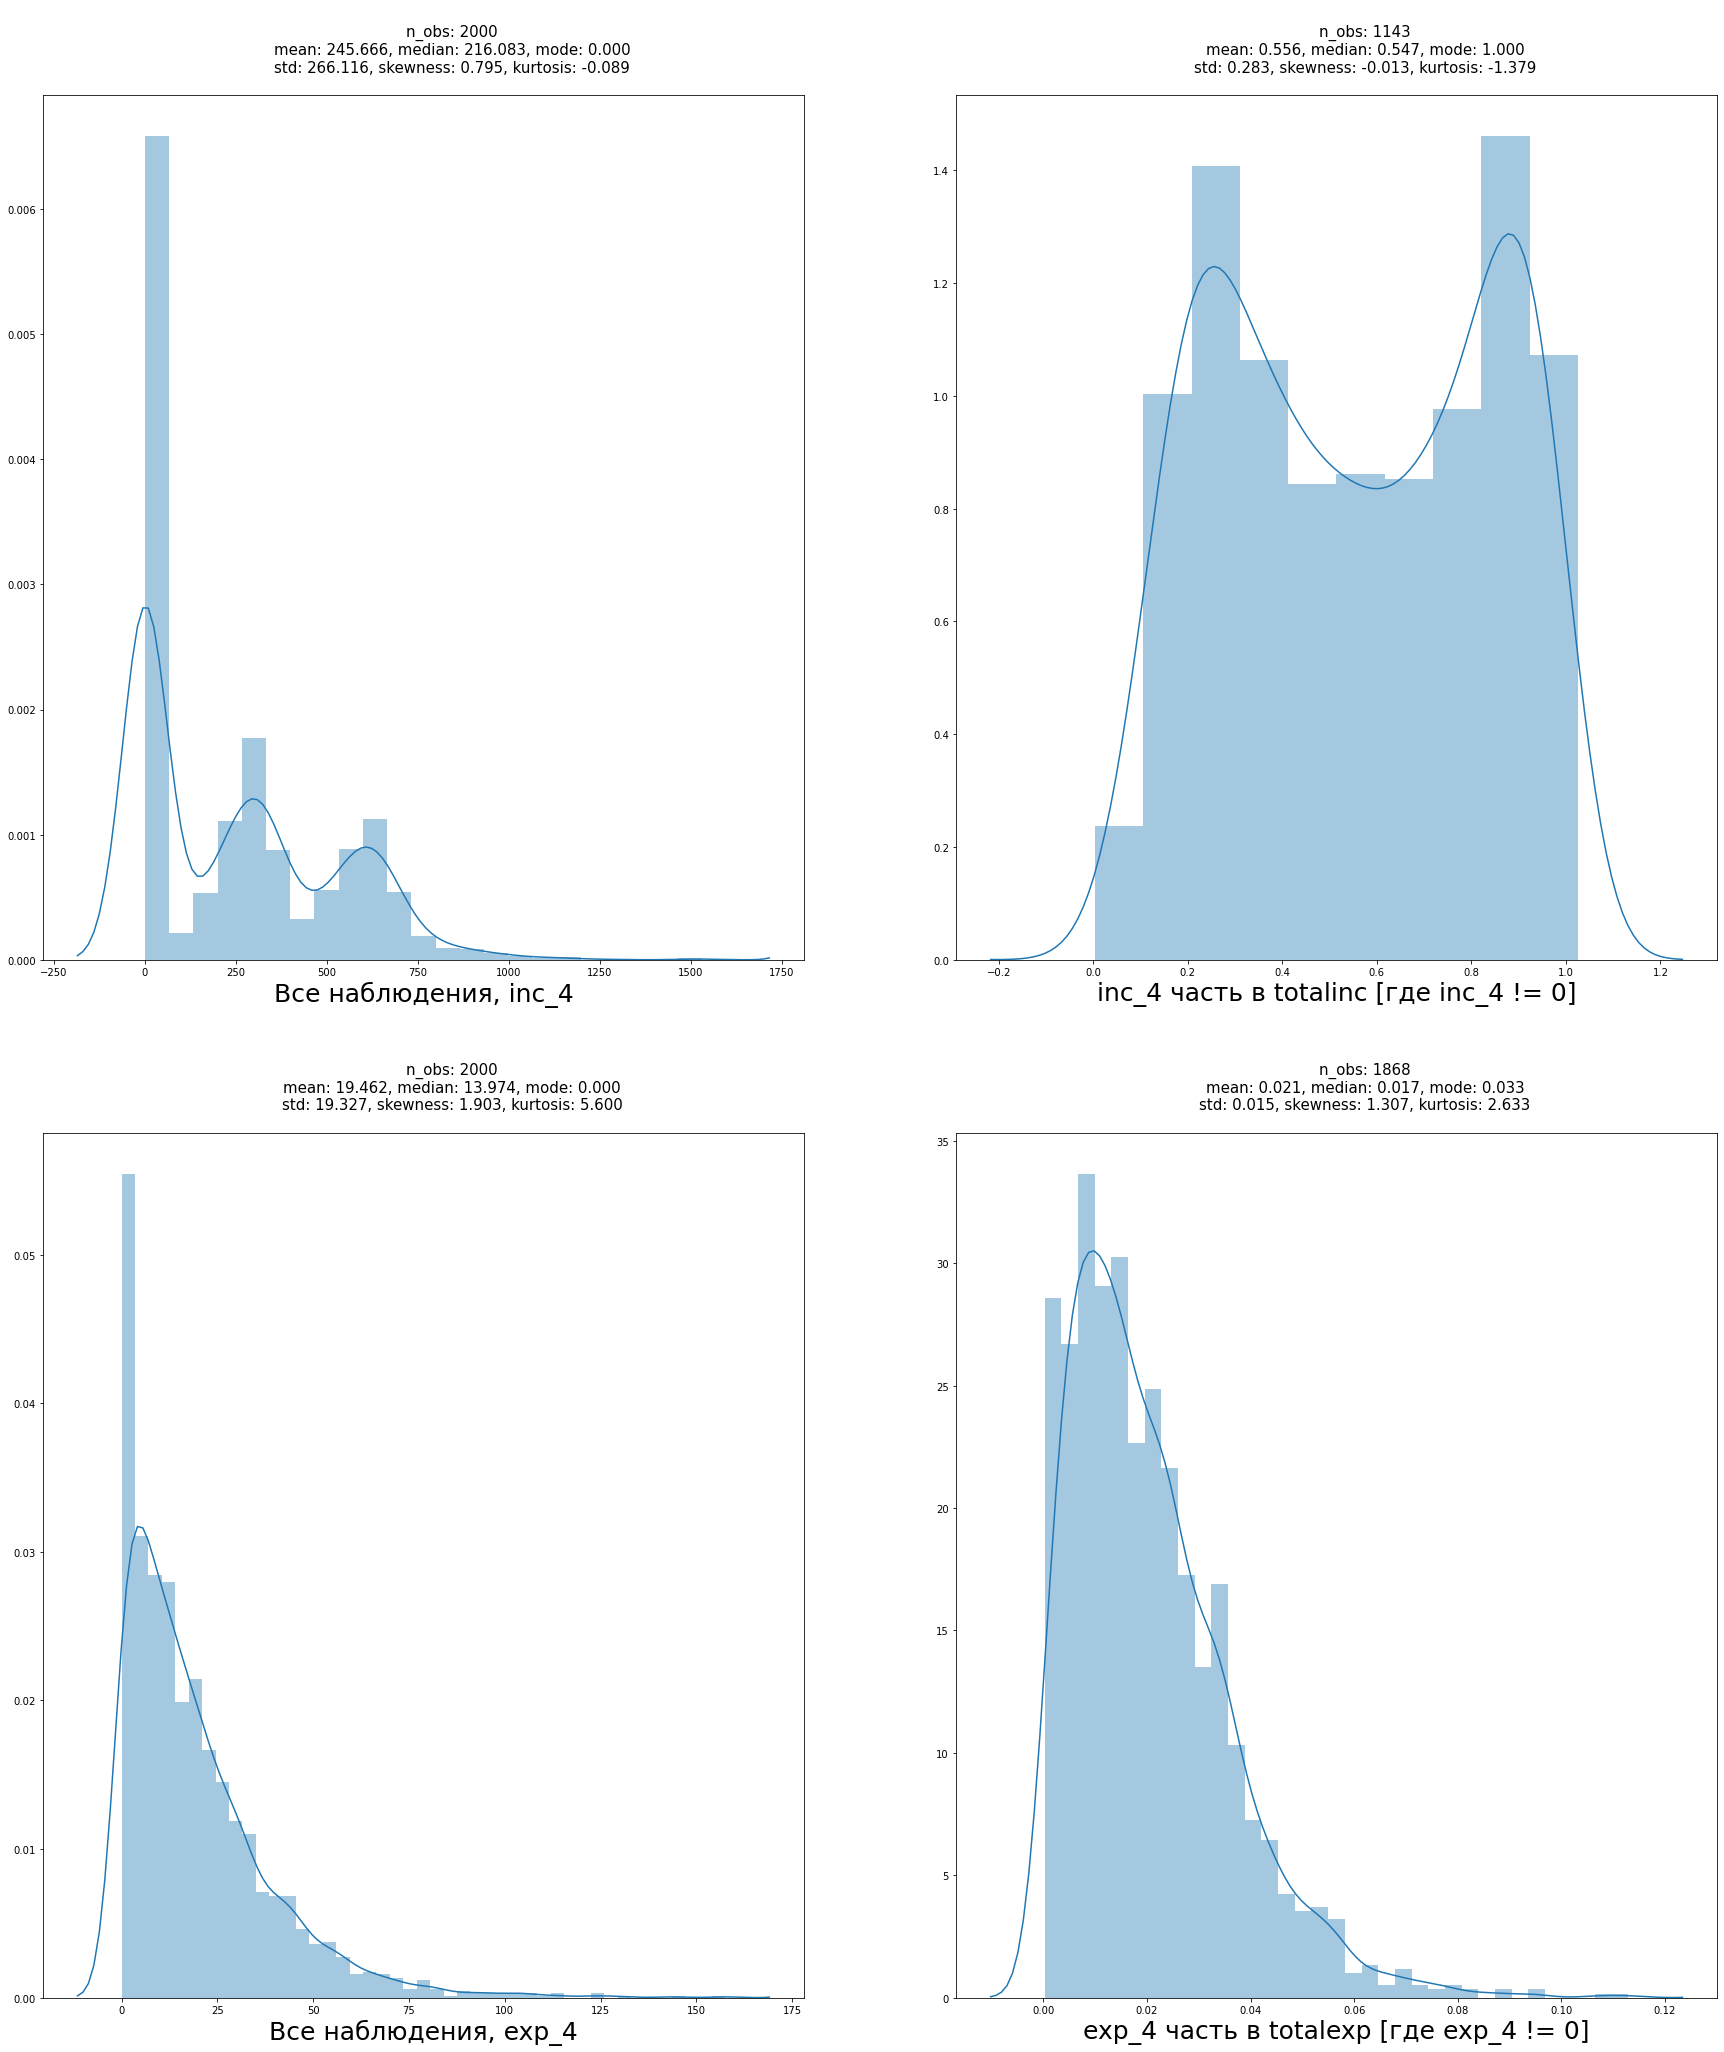

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(30, 35))

sns.distplot(df["inc_4"], ax=axes[0][0]).set_title(
    get_stats(df["inc_4"]), fontsize=15)
axes[0][0].set_xlabel("Все наблюдения, inc_4", fontsize=25)
    
nonzero_inc4_fraction = df[df["inc_4"] != 0]["inc_4"]/df[df["inc_4"] != 0]["totalinc"]
sns.distplot(nonzero_inc4_fraction, ax=axes[0][1]).set_title(
    get_stats(nonzero_inc4_fraction), fontsize=15)
axes[0][1].set_xlabel(f"inc_4 часть в totalinc [где inc_4 != 0]", fontsize=25)

sns.distplot(df["exp_4"], ax=axes[1][0]).set_title(
    get_stats(df["exp_4"]), fontsize=15)
axes[1][0].set_xlabel("Все наблюдения, exp_4", fontsize=25)

nonzero_exp4_fraction = df[df["exp_4"] != 0]["exp_4"]/df[df["exp_4"] != 0]["totalexp"]
sns.distplot(nonzero_exp4_fraction, ax=axes[1][1]).set_title(
    get_stats(nonzero_exp4_fraction), fontsize=15)
axes[1][1].set_xlabel(f"exp_4 часть в totalexp [где exp_4 != 0]", fontsize=25)

####    Возраст (age) имеет распределение, похожее на равномерное (от 30 до 70 лет), чуть меньше наблюдений до 30 лет (вероятно, это связано с особенностью проведения опроса) и после 70 лет (вероятно, это связано с тем, что эта возрастная группа меньше представлена в нашей стране)
####    Вес (weight) имеет нормальное распределение с центром в 77 кг (редко встречаются "выбросы" больше 120 кг)
####    Рост(height) имеет нормальное распределение с центром в 168 см (без выбросов как для веса, что логично)
####    Индекс массы тела (BMI) также почти имеет нормальное распределение с центром в 26 (но из-за "выбросов" с ИМТ > 40 появляется небольшое смещение)

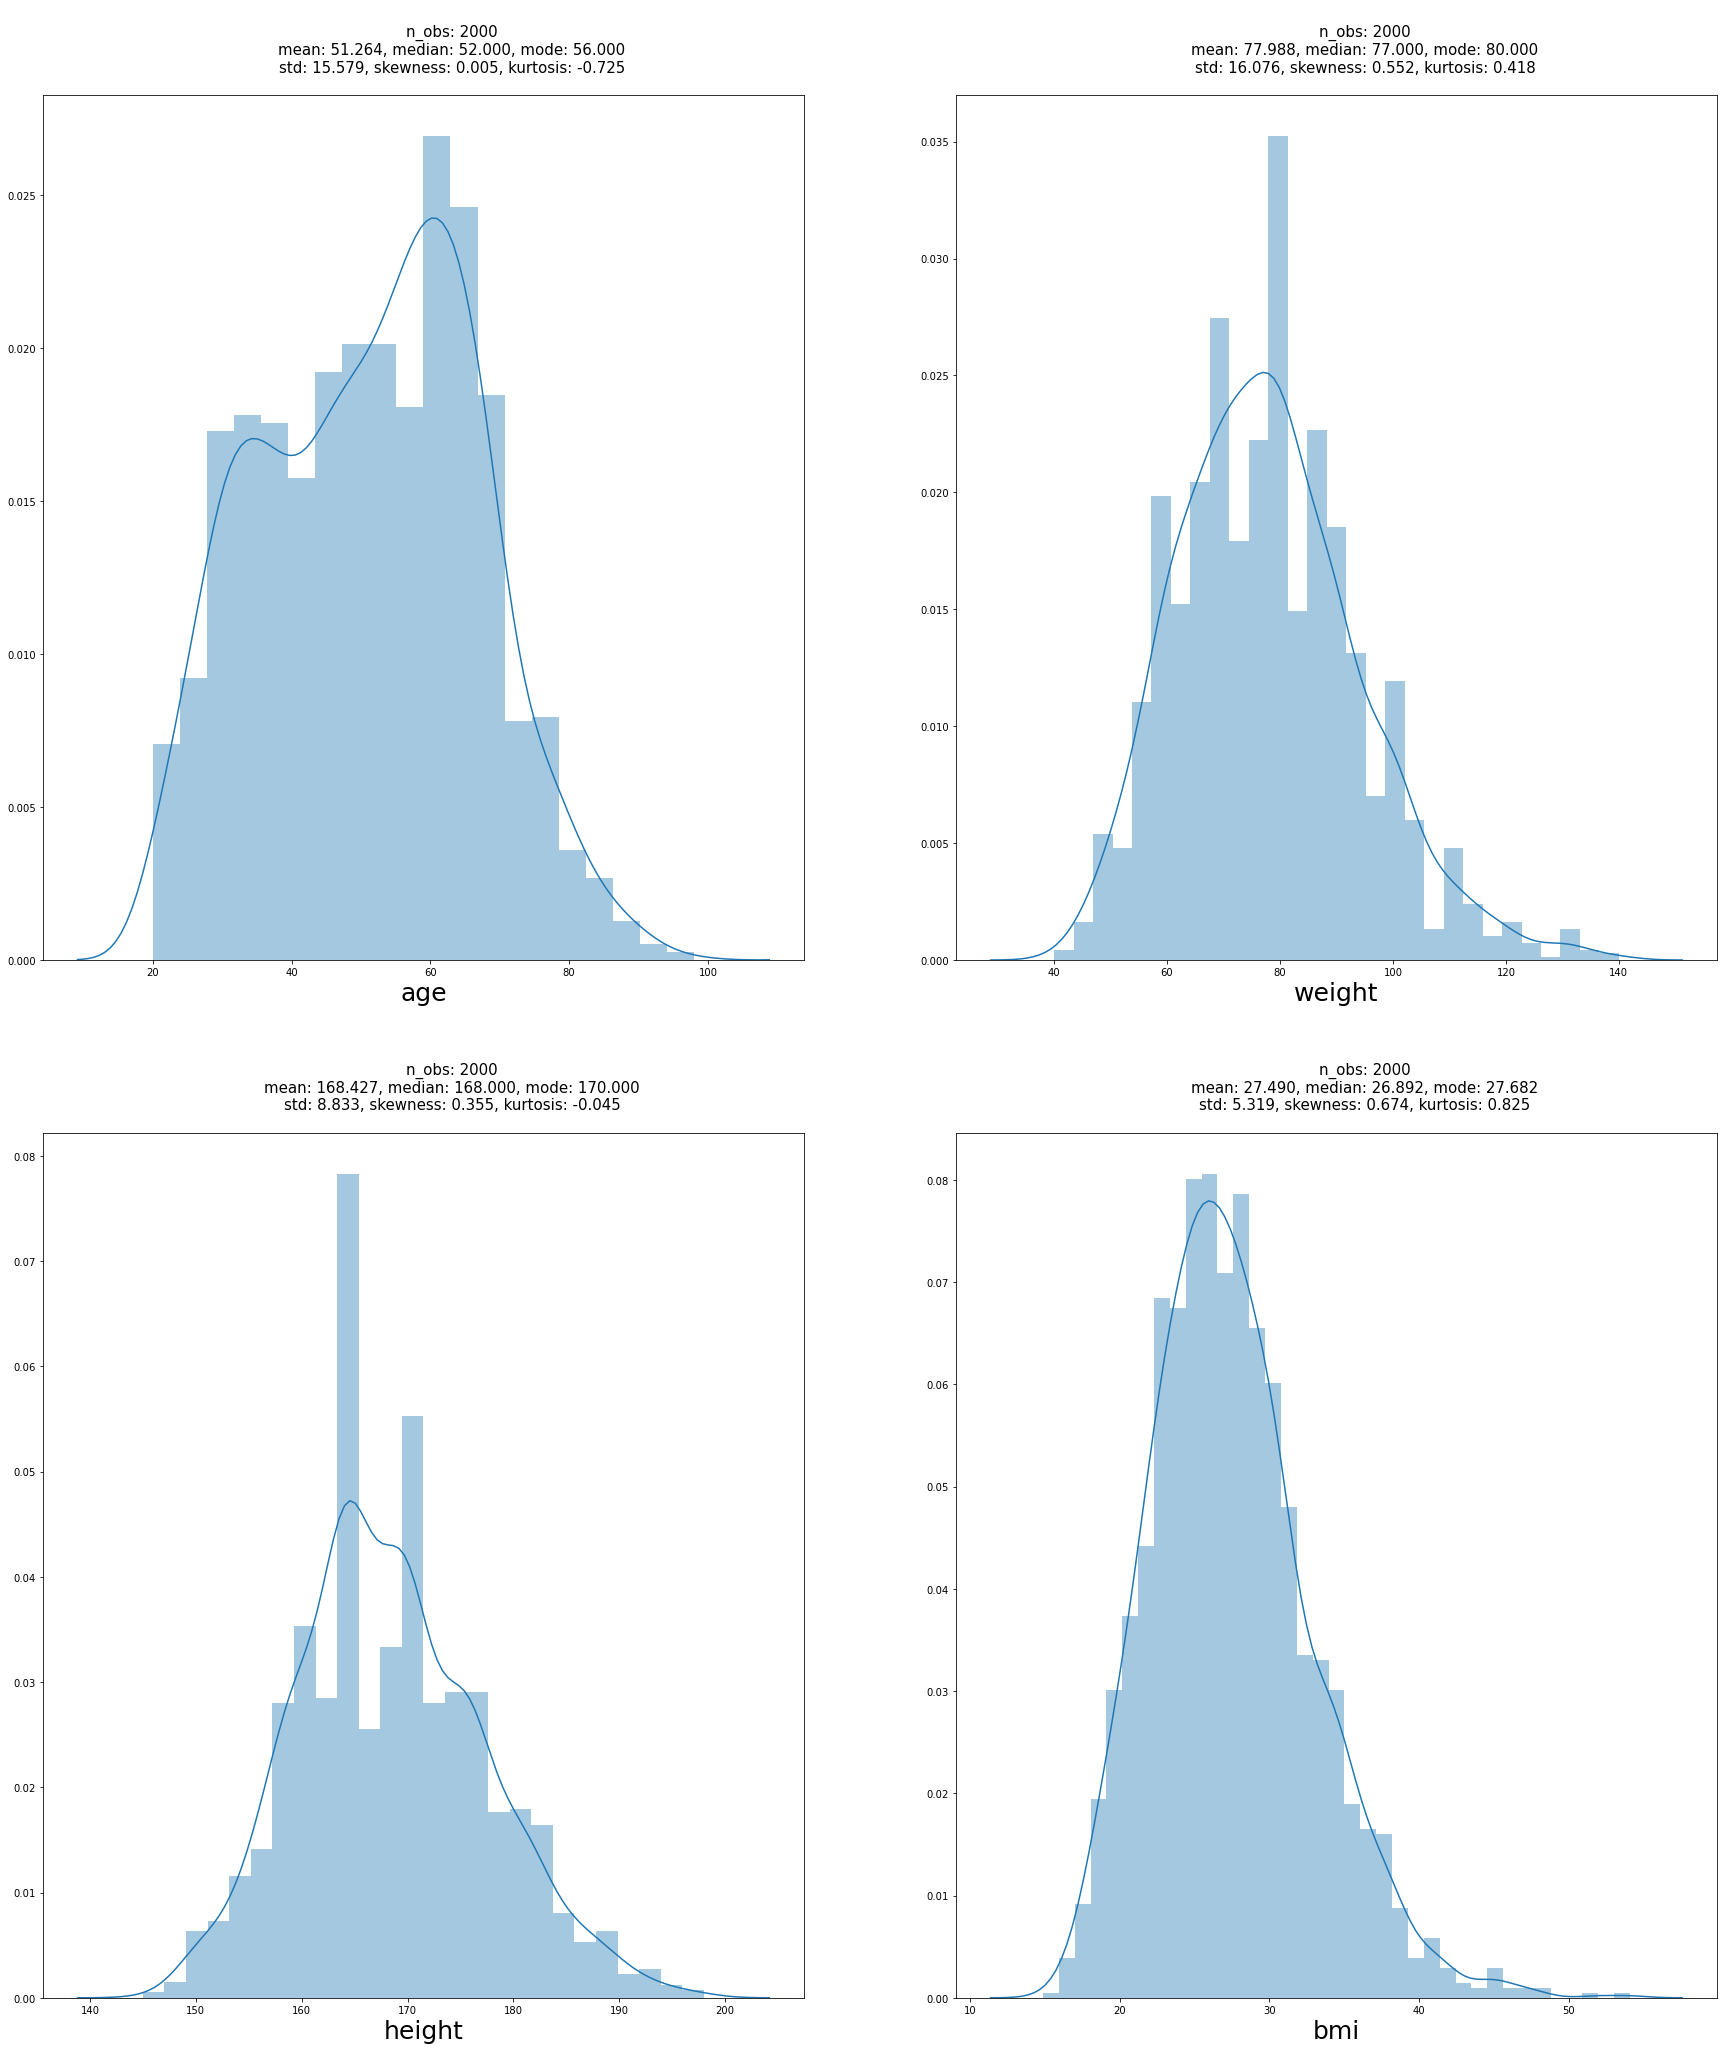

In [10]:
cols_to_plot = ["age", "weight", "height", "bmi"]
fig, axes = plt.subplots(2, 2, figsize=(30, 35))
axes = axes.reshape(-1)

for i in range(len(cols_to_plot)):
    col = cols_to_plot[i]
    sns.distplot(df[col], ax=axes[i]).set_title(get_stats(df[col]), fontsize=15)
    axes[i].set_xlabel(col, fontsize=25)

🔘 Женщин в датасете больше, чем мужчин: 1200 v 800

🔘 Регионы представлены примерно одинаково. Меньше всего - в Гродненской области (12.15%), больше всего - в Гомельской (16.30%). В Минске живет 2 млн человек (больше 20% населения страны), а в датасете его 13.75%. Хотя на взвешенной выборке ситуация меняется и Минск в ней представлен больше всего

🔘 По типам домохозяйств доминируют "2 и более взрослых с детьми" и "домохозяйство без детей", меньше всего семей с одним родителем

🔘 Самые распространённые домохозяйства - из двух (для невзвешенной выборки) и двух-трёх человек (для взвешенной выборки)

🔘 Самый популярный уровень образования - средне-специальное, меньше всего по уровню образования людей без него вовсе

🔘 Большинство оценивает своё здоровье как нормальное (не очень хорошее, не очень плохое). Людей, считающий, что у них хорошее здоровье в 2 раза больше, чем считающих, что плохое

Невзвешенная выборка:


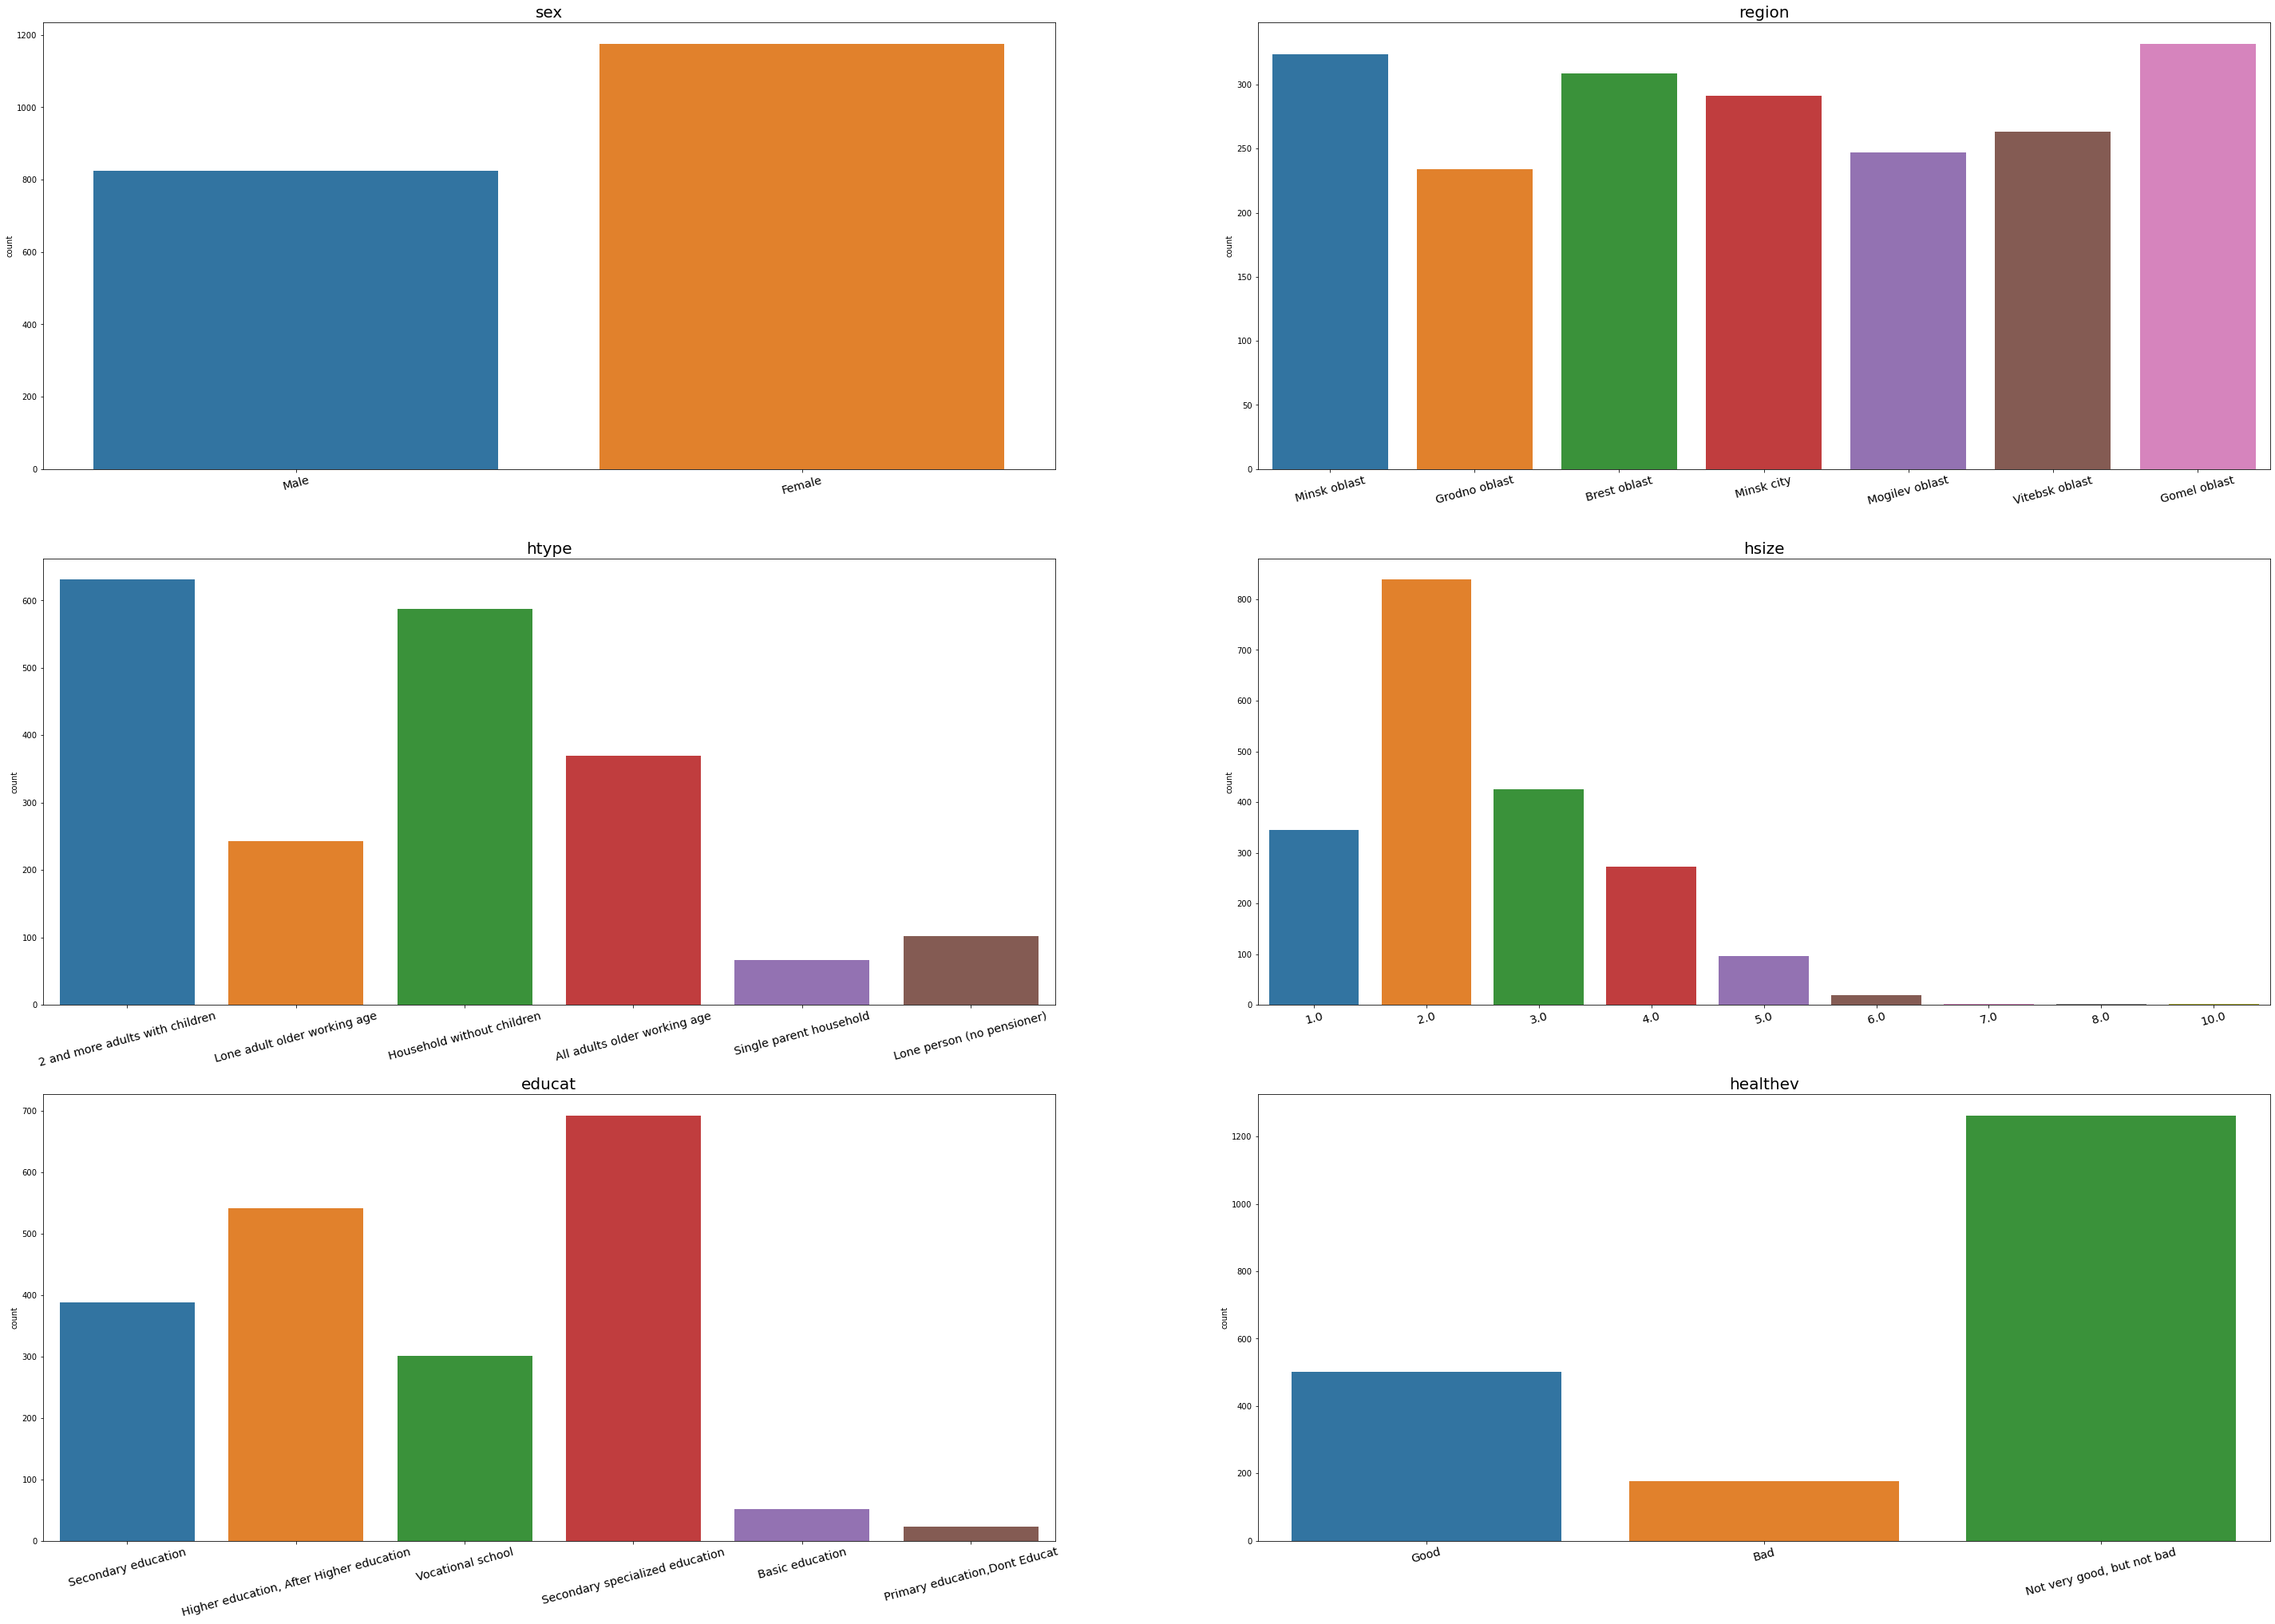

In [11]:
cols_to_plot = ["sex", "region", "htype", "hsize", "educat", "healthev"]
fig, axes = plt.subplots(3, 2, figsize=(50, 35))
axes = axes.reshape(-1)
for i in range(len(cols_to_plot)):
    col = cols_to_plot[i]
    sns.countplot(df[~df[col].isna()][col], ax=axes[i]).set_title(col, fontsize=20)
    plt.setp(axes[i].get_xticklabels(), rotation=15, fontsize='x-large')
    axes[i].set_xlabel(None)
    
print("Невзвешенная выборка:")

Взвешенная выборка:


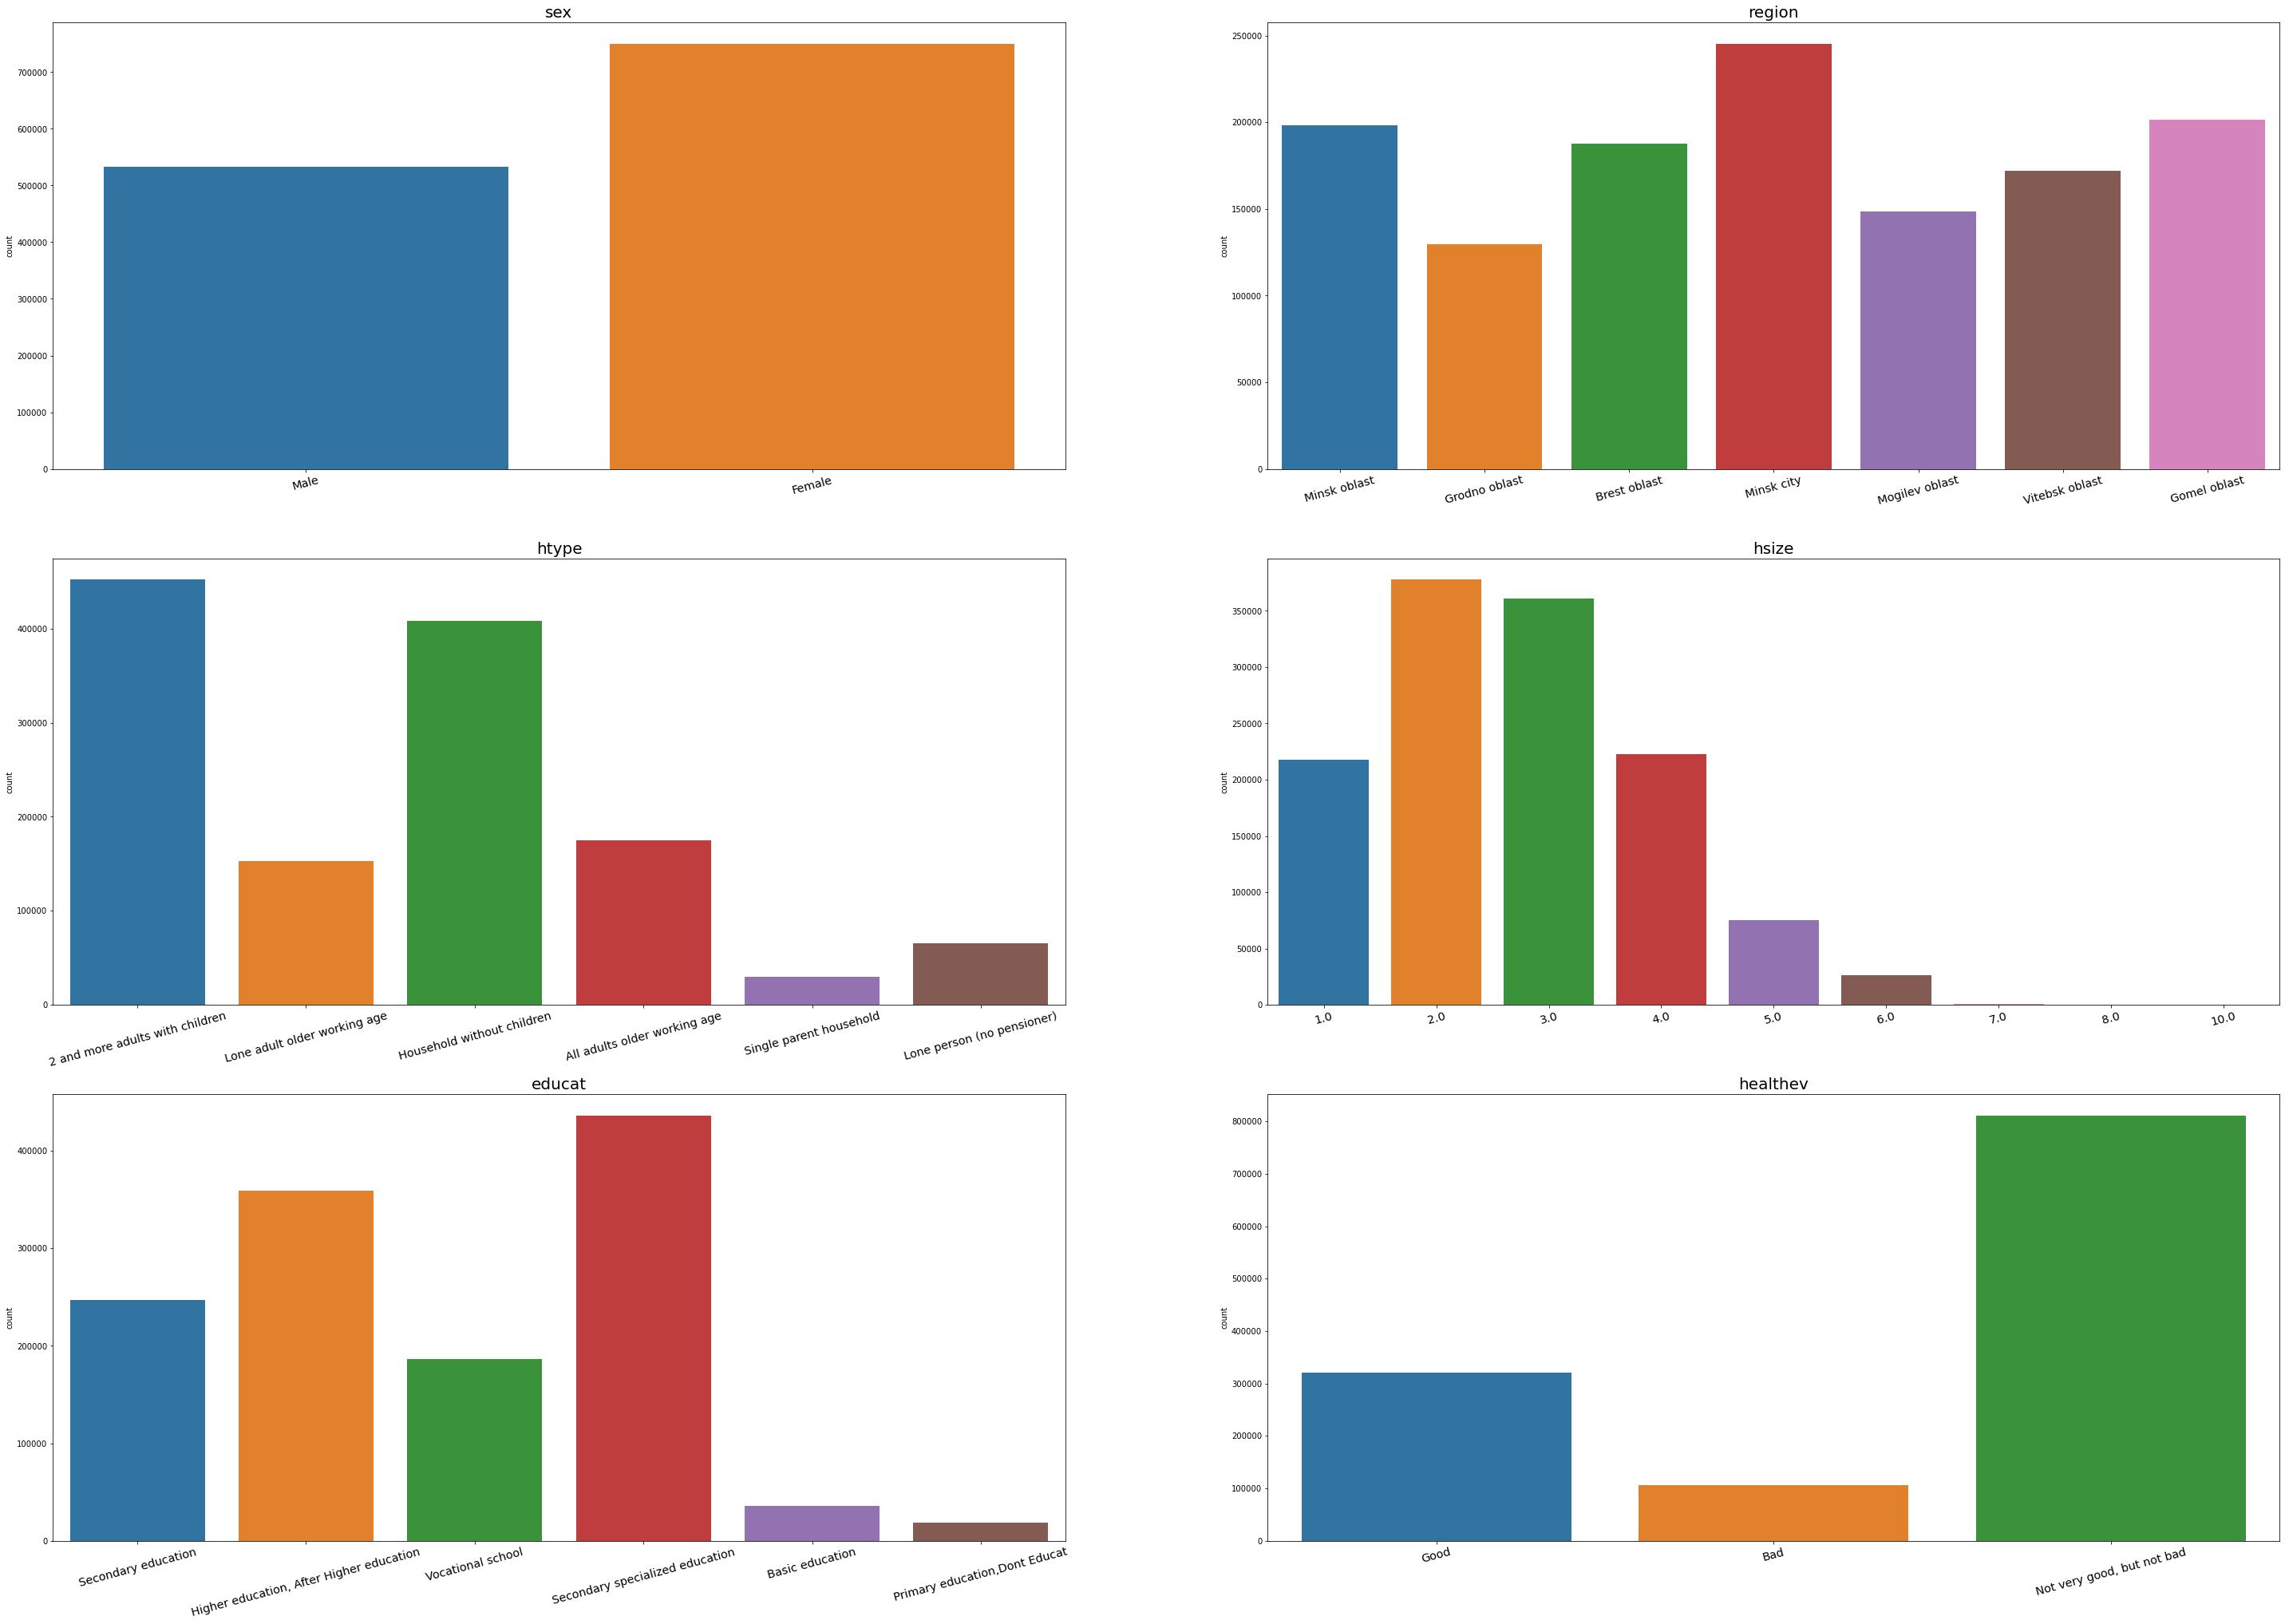

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(50, 35))
axes = axes.reshape(-1)
for i in range(len(cols_to_plot)):
    col = cols_to_plot[i]
    sns.countplot(weighted_df[~weighted_df[col].isna()][col], ax=axes[i]).set_title(col, fontsize=20)
    plt.setp(axes[i].get_xticklabels(), rotation=15, fontsize='x-large')
    axes[i].set_xlabel(None)
    
print("Взвешенная выборка:")

Распределения зарплат (ppinc_1) и сбережений (savings) не сильно меняются для взвешенной и невзвешенной выборки, что говорит о репрезентативности выборки по этим параметрам.
Почти все зарплаты находятся в промежутке от 0 до 1500 рублей. В среднем люди "живут в ноль": не откладывают и не уходят в минусы, у большинства не получается откладывать больше 500 рублей. Треть страны живёт "в минус"

Text(0.5, 0, 'Взвешенная savings')

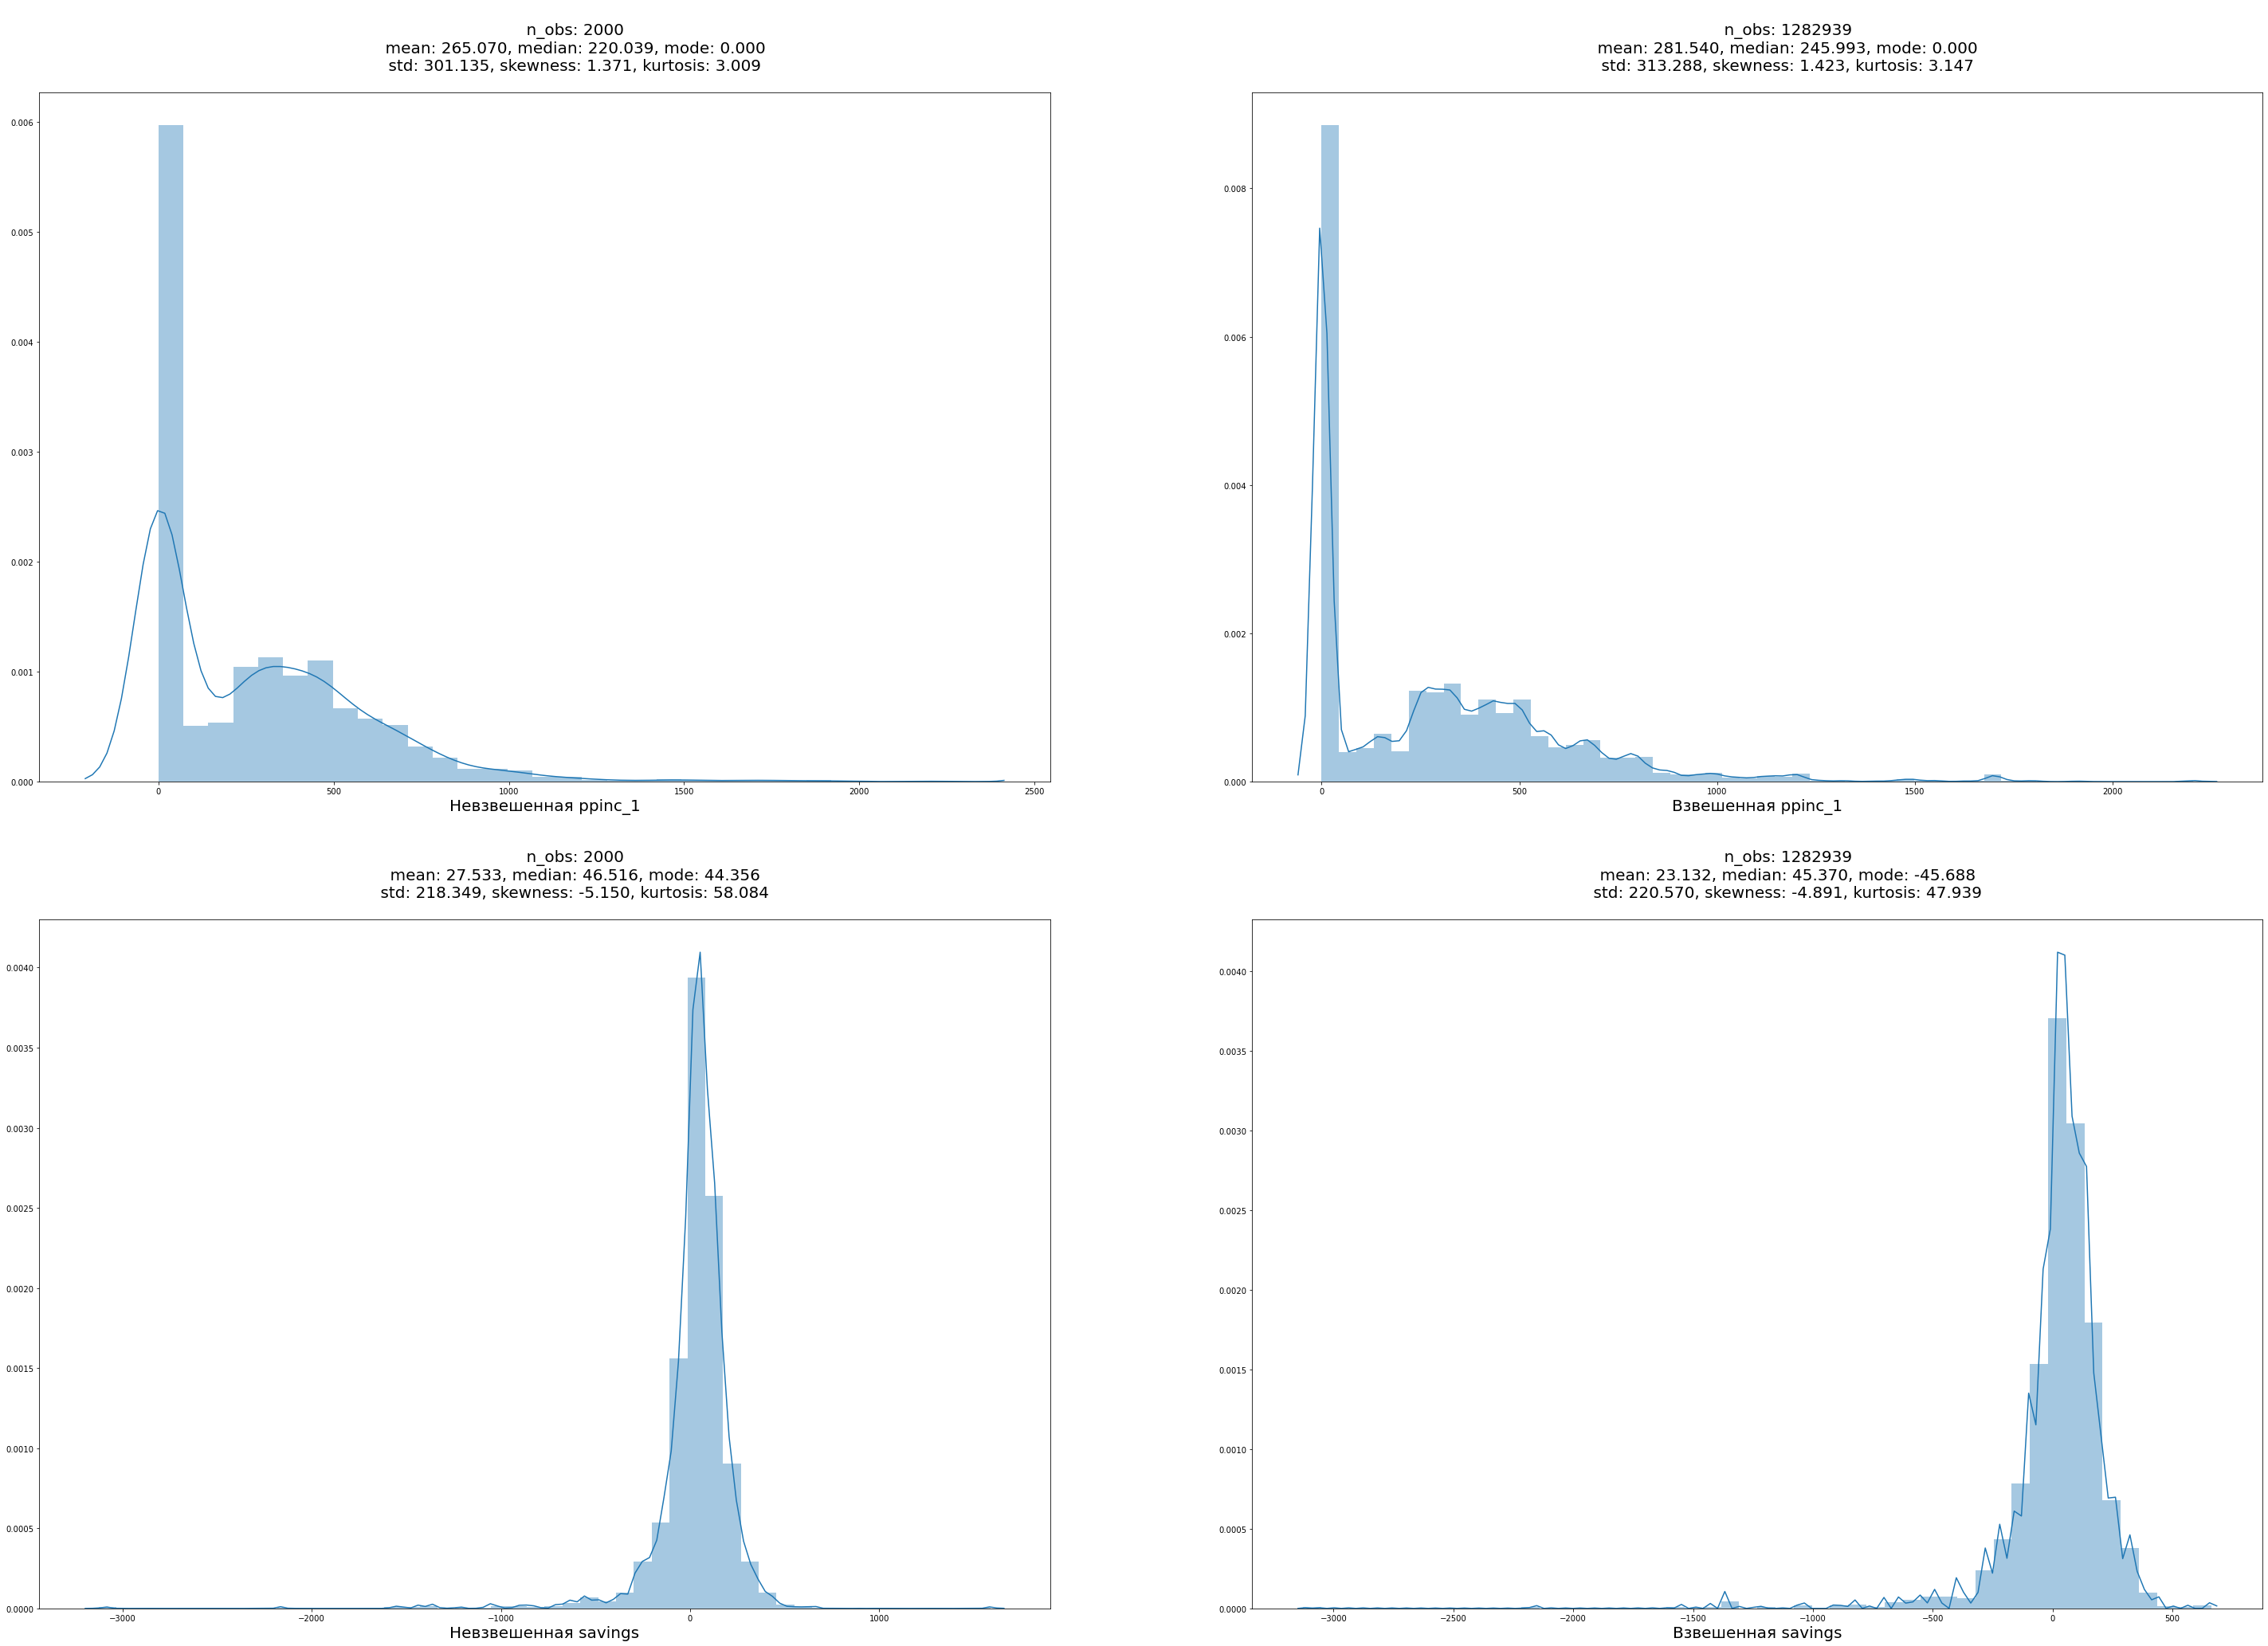

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(50, 35))
axes = axes.reshape(-1)

sns.distplot(df["ppinc_1"], ax=axes[0]).set_title(get_stats(df["ppinc_1"]), fontsize=20)
axes[0].set_xlabel("Невзвешенная ppinc_1", fontsize=20)

sns.distplot(weighted_df["ppinc_1"], ax=axes[1]).set_title(get_stats(weighted_df["ppinc_1"]), fontsize=20)
axes[1].set_xlabel("Взвешенная ppinc_1", fontsize=20)


sns.distplot(df["savings"], ax=axes[2]).set_title(get_stats(df["savings"]), fontsize=20)
axes[2].set_xlabel("Невзвешенная savings", fontsize=20)

sns.distplot(weighted_df["savings"], ax=axes[3]).set_title(get_stats(weighted_df["savings"]), fontsize=20)
axes[3].set_xlabel("Взвешенная savings", fontsize=20)

# 3. Анализ преобразованных значений количественных переменных

Логарифмическое преобразование делает распределение признаков totalinc, totalexp намного ближе к нормальному
Признаки inc_4/totalinc (для ненулевых inc_4) и exp_4/totalexp (для ненулевых exp_4) не являются лог-нормальными, поэтому данное преобразование не помогло
Признаки weight, height и bmi и так были нормально распределенными, так что это преобразование им не нужно

Стандартизация (приведение к нулевому среднему и единичной дисперсии) не изменила форму распределения данных, а только их масштаб.

Text(0.5, 0, 'standardize(exp_4 часть)')

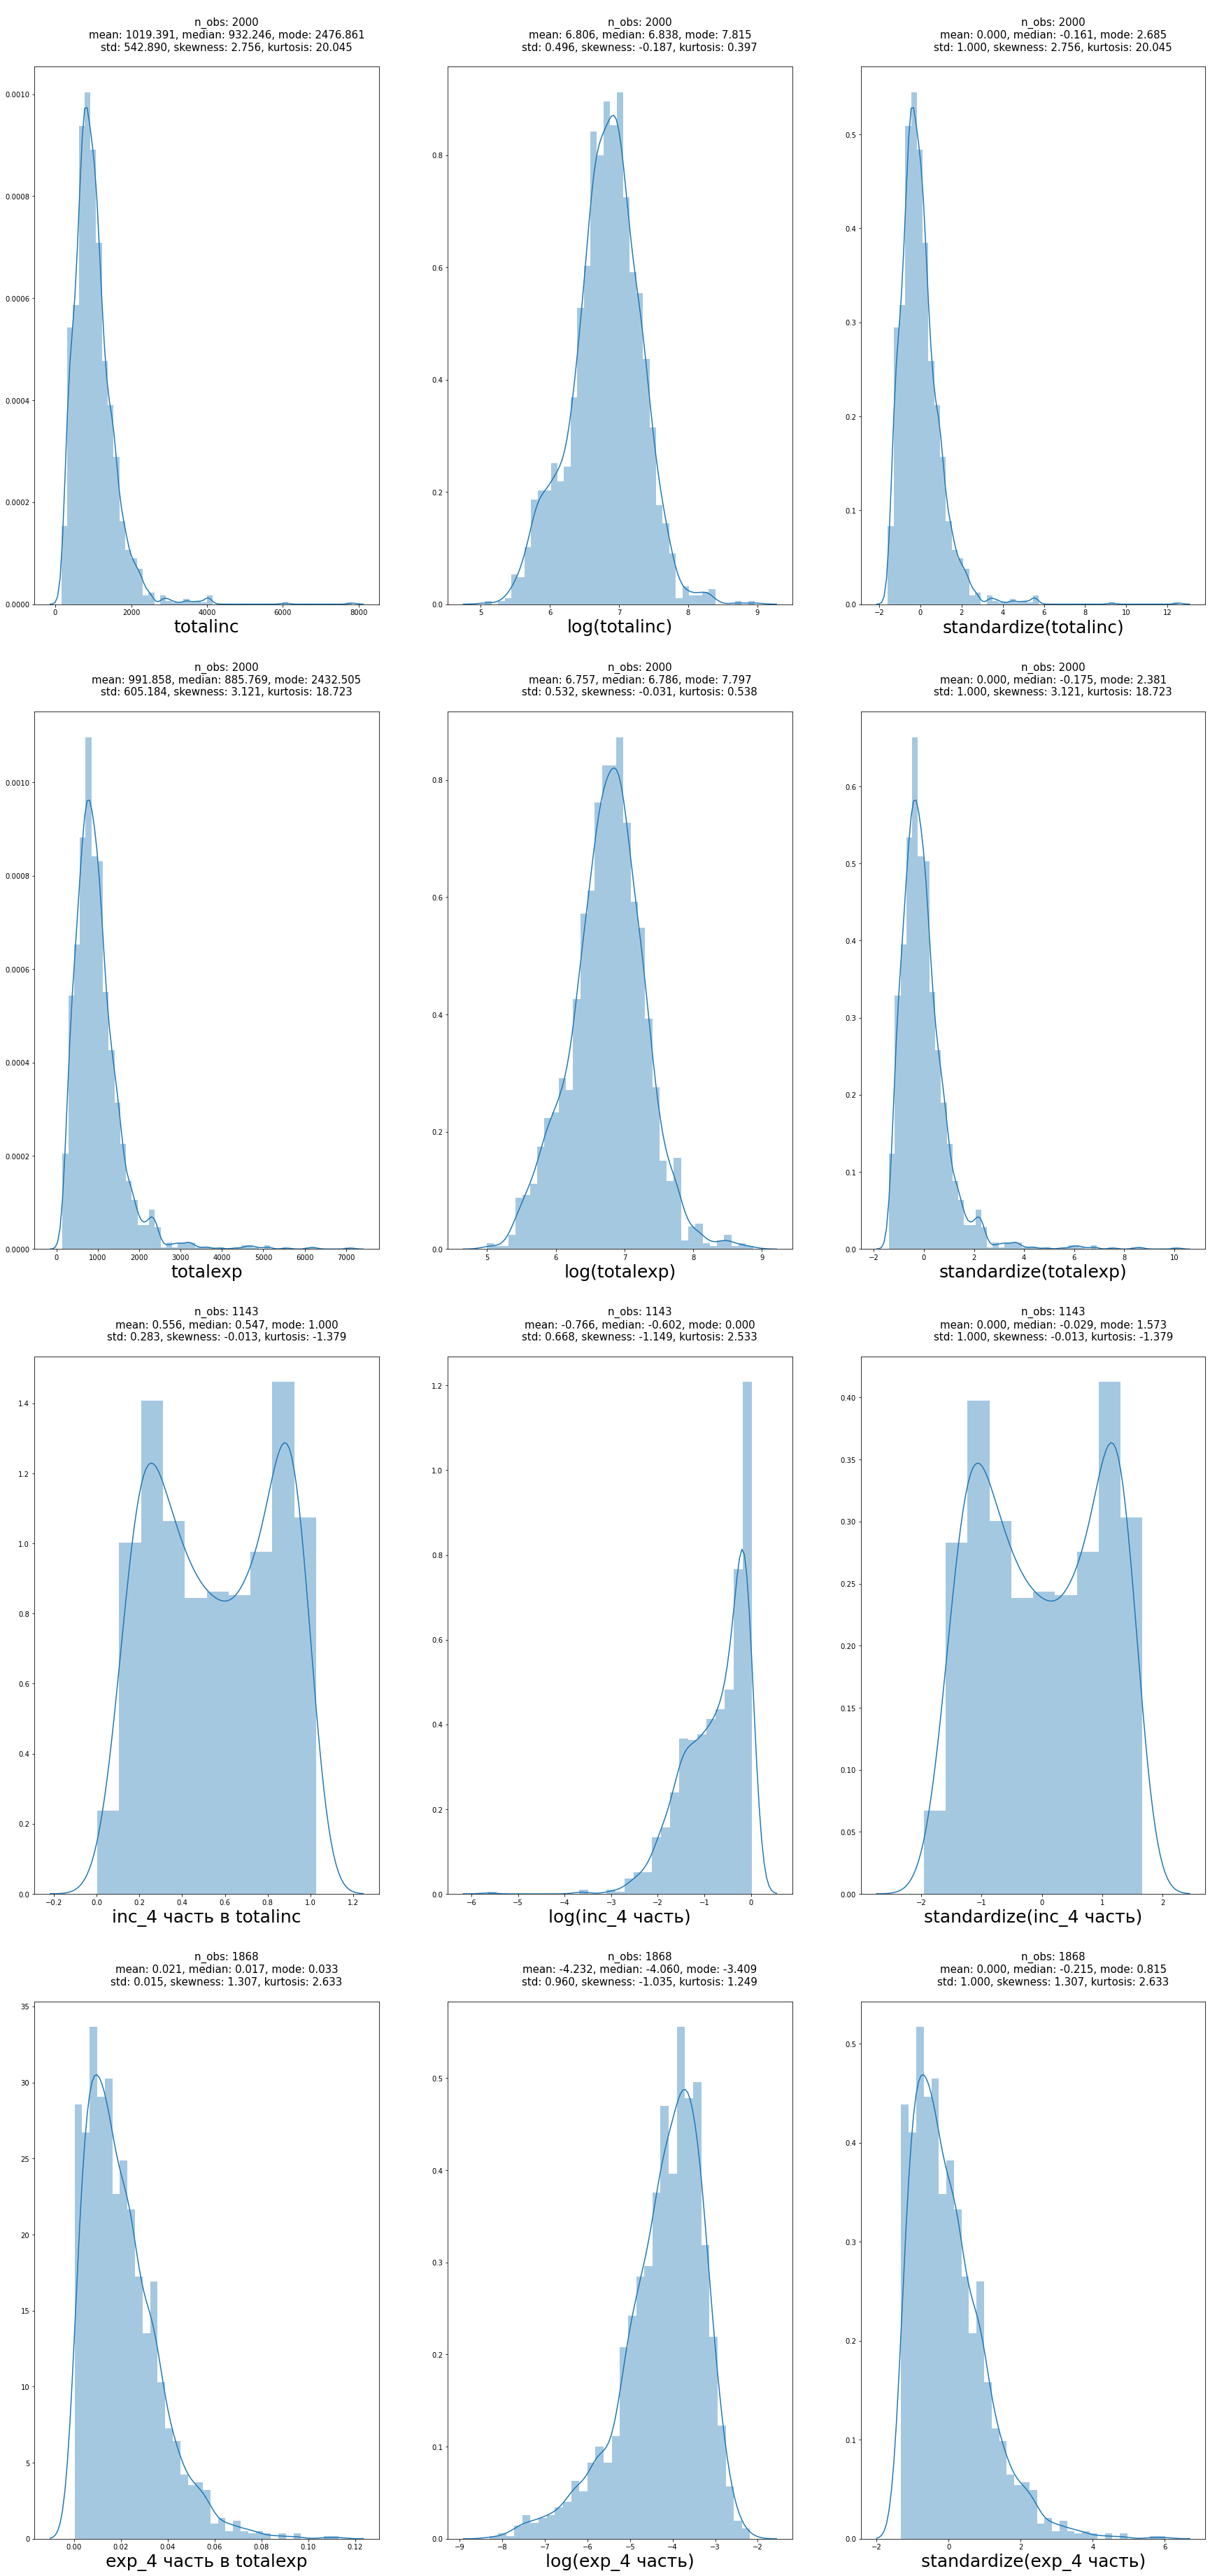

In [15]:
fig, axes = plt.subplots(4, 3, figsize=(30, 65))

sns.distplot(df["totalinc"], ax=axes[0][0]).set_title(
    get_stats(df["totalinc"]), fontsize=15
)
axes[0][0].set_xlabel("totalinc", fontsize=25)
    
log_totalinc = np.log(df["totalinc"])
sns.distplot(log_totalinc, ax=axes[0][1]).set_title(
    get_stats(log_totalinc), fontsize=15
)
axes[0][1].set_xlabel(f"log(totalinc)", fontsize=25)

standard_totalinc = standardize(df["totalinc"])
sns.distplot(standard_totalinc, ax=axes[0][2]).set_title(
    get_stats(standard_totalinc), fontsize=15
)
axes[0][2].set_xlabel(f"standardize(totalinc)", fontsize=25)

sns.distplot(df["totalexp"], ax=axes[1][0]).set_title(
    get_stats(df["totalexp"]), fontsize=15
)
axes[1][0].set_xlabel("totalexp", fontsize=25)
    
log_totalexp = np.log(df["totalexp"])
sns.distplot(log_totalexp, ax=axes[1][1]).set_title(
    get_stats(log_totalexp), fontsize=15
)
axes[1][1].set_xlabel(f"log(totalexp)", fontsize=25)

standard_totalexp = standardize(df["totalexp"])
sns.distplot(standard_totalexp, ax=axes[1][2]).set_title(
    get_stats(standard_totalexp), fontsize=15
)
axes[1][2].set_xlabel(f"standardize(totalexp)", fontsize=25)

sns.distplot(nonzero_inc4_fraction, ax=axes[2][0]).set_title(
    get_stats(nonzero_inc4_fraction), fontsize=15
)
axes[2][0].set_xlabel(f"inc_4 часть в totalinc", fontsize=25)

sns.distplot(np.log(nonzero_inc4_fraction), ax=axes[2][1]).set_title(
    get_stats(np.log(nonzero_inc4_fraction)), fontsize=15
)
axes[2][1].set_xlabel(f"log(inc_4 часть)", fontsize=25)

sns.distplot(standardize(nonzero_inc4_fraction), ax=axes[2][2]).set_title(
    get_stats(standardize(nonzero_inc4_fraction)), fontsize=15
)
axes[2][2].set_xlabel(f"standardize(inc_4 часть)", fontsize=25)

sns.distplot(nonzero_exp4_fraction, ax=axes[3][0]).set_title(
    get_stats(nonzero_exp4_fraction), fontsize=15
)
axes[3][0].set_xlabel(f"exp_4 часть в totalexp", fontsize=25)

sns.distplot(np.log(nonzero_exp4_fraction), ax=axes[3][1]).set_title(
    get_stats(np.log(nonzero_exp4_fraction)), fontsize=15
)
axes[3][1].set_xlabel(f"log(exp_4 часть)", fontsize=25)

sns.distplot(standardize(nonzero_exp4_fraction), ax=axes[3][2]).set_title(
    get_stats(standardize(nonzero_exp4_fraction)), fontsize=15
)
axes[3][2].set_xlabel(f"standardize(exp_4 часть)", fontsize=25)